熊双宇 10174102103

# 图像特征练习
*补充并完成本练习。*

我们已经看到，通过在输入图像的像素上训练线性分类器，从而在图像分类任务上达到一个合理的性能。在本练习中，我们将展示我们可以通过对线性分类器（不是在原始像素上，而是在根据原始像素计算出的特征上）进行训练来改善分类性能。

你将在此notebook中完成本练习的所有工作。

In [2]:
import random
import numpy as np
from daseCV.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 数据加载
与之前的练习类似，我们将从磁盘加载CIFAR-10数据。

In [3]:
from daseCV.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'daseCV/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## 特征提取
对于每一张图片我们将会计算它的方向梯度直方图（英語：Histogram of oriented gradient，简称HOG）以及在HSV颜色空间使用色相通道的颜色直方图。

简单来讲，HOG能提取图片的纹理信息而忽略颜色信息，颜色直方图则提取出颜色信息而忽略纹理信息。
因此，我们希望将两者结合使用而不是单独使用任一个。去实现这个设想是一个十分有趣的事情。

`hog_feature` 和 `color_histogram_hsv`两个函数都可以对单个图像进行运算并返回改图像的一个特征向量。
extract_features函数输入一个图像集合和一个特征函数列表然后对每张图片运行每个特征函数，
然后将结果存储在一个矩阵中，矩阵的每一列是单个图像的所有特征向量的串联。

In [4]:
from daseCV.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## 使用特征训练SVM
使用之前作业完成的多分类SVM代码来训练上面提取的特征。这应该比原始数据直接在SVM上训练会去的更好的效果。

In [5]:
# 使用验证集调整学习率和正则化强度

from daseCV.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# 你需要做的: 
# 使用验证集设置学习率和正则化强度。
# 这应该与你对SVM所做的验证相同；
# 将训练最好的的分类器保存在best_svm中。
# 你可能还想在颜色直方图中使用不同数量的bins。
# 如果你细心一点应该能够在验证集上获得接近0.44的准确性。    
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                              num_iters=1500, batch_size=200, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
# pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 86.355994
iteration 100 / 1500: loss 84.831750
iteration 200 / 1500: loss 83.334527
iteration 300 / 1500: loss 81.861970
iteration 400 / 1500: loss 80.414893
iteration 500 / 1500: loss 79.008581
iteration 600 / 1500: loss 77.615815
iteration 700 / 1500: loss 76.241857
iteration 800 / 1500: loss 74.923270
iteration 900 / 1500: loss 73.614783
iteration 1000 / 1500: loss 72.322810
iteration 1100 / 1500: loss 71.075538
iteration 1200 / 1500: loss 69.852608
iteration 1300 / 1500: loss 68.644194
iteration 1400 / 1500: loss 67.469409
iteration 0 / 1500: loss 785.579269
iteration 100 / 1500: loss 644.758785
iteration 200 / 1500: loss 529.457680
iteration 300 / 1500: loss 435.079463
iteration 400 / 1500: loss 357.791367
iteration 500 / 1500: loss 294.543015
iteration 600 / 1500: loss 242.759361
iteration 700 / 1500: loss 200.364286
iteration 800 / 1500: loss 165.668570
iteration 900 / 1500: loss 137.253739
iteration 1000 / 1500: loss 113.995426
iteration 1100 / 1500: lo

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.418


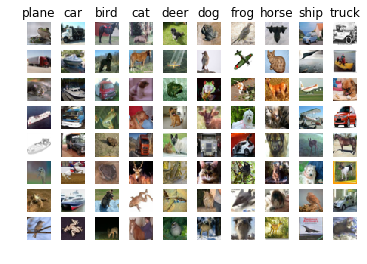

In [7]:
# 直观了解算法工作原理的一种重要方法是可视化它所犯的错误。
# 在此可视化中，我们显示了当前系统未正确分类的图像示例。
# 第一列显示的图像是我们的系统标记为“ plane”，但其真实标记不是“ plane”。

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

**问题 1:**

描述你看到的错误分类结果。你认为他们有道理吗？

$\color{blue}{\textit 答:}$ 
** 大部分有道理, 因为误分类的类别的一些局部特征(形状/纹理等)和图像的局部特征有相似之处; 此外, 也有可能是背景等因素导致误分类, 这则说明神经网络学习到一些 undesired 的特征(如果这个说法有误, 希望老师/助教指正)** 

## 图像特征神经网络
在之前的练习中，我们看到在原始像素上训练两层神经网络比线性分类器具有更好的分类精度。在这里，我们已经看到使用图像特征的线性分类器优于使用原始像素的线性分类器。
为了完整起见，我们还应该尝试在图像特征上训练神经网络。这种方法应优于以前所有的方法：你应该能够轻松地在测试集上达到55％以上的分类精度；我们最好的模型可达到约60％的精度。

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [11]:
from daseCV.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10
best_acc = 0.0

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: 使用图像特征训练两层神经网络。
# 您可能希望像上一节中那样对各种参数进行交叉验证。
# 将最佳的模型存储在best_net变量中。                                             
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# batch_sizes = [200, 400]
batch_size = 200
learning_rates = [5e-2,7.5e-2,1e-1,2.5e-1,5e-1]
regs = [1e-6,5e-6,1e-5,5e-5,1e-4]
results = {}
best_val = 0.0
for lr in learning_rates:
    for reg in regs:
#         for batch_size in batch_sizes:
                net = TwoLayerNet(input_dim, hidden_dim, num_classes)
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                            num_iters=1000, batch_size=200,
                            learning_rate=lr, learning_rate_decay=0.95,
                            reg=reg, verbose=True)
                # predict
                y_train_pred = net.predict(X_train_feats)
                train_acc = np.mean(y_train_pred == y_train)
                y_val_pred = net.predict(X_val_feats)
                val_acc = np.mean(y_val_pred == y_val)
                
                # results
                results[(lr, reg, batch_size)] = (train_acc, val_acc)
                
                # best:
                if best_val < val_acc:
                    best_stats = stats
                    best_val = val_acc
                    best_net = net


# Print out results. 

for lr, reg, batch_size in sorted(results): 

    val_acc = results[(lr, reg, batch_size)] 

    print('lr %e reg %e batch_size %d  val accuracy: %f' % (lr, reg, batch_size, val_acc)) 
print('best validation accuracy achieved during cross-validation: %f' % best_val) 
# pass
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302135
iteration 200 / 1000: loss 2.300867
iteration 300 / 1000: loss 2.290518
iteration 400 / 1000: loss 2.137575
iteration 500 / 1000: loss 1.947864
iteration 600 / 1000: loss 1.856158
iteration 700 / 1000: loss 1.665591
iteration 800 / 1000: loss 1.709395
iteration 900 / 1000: loss 1.491571
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302757
iteration 200 / 1000: loss 2.302445
iteration 300 / 1000: loss 2.285618
iteration 400 / 1000: loss 2.160419
iteration 500 / 1000: loss 1.947257
iteration 600 / 1000: loss 1.817944
iteration 700 / 1000: loss 1.852855
iteration 800 / 1000: loss 1.654100
iteration 900 / 1000: loss 1.553805
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302275
iteration 200 / 1000: loss 2.302681
iteration 300 / 1000: loss 2.287914
iteration 400 / 1000: loss 2.120216
iteration 500 / 1000: loss 1.910226
iteration 600 / 1000: loss 1.806117
iteration 700 / 1000: loss 1.67345

iteration 900 / 1000: loss 1.115387
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.511615
iteration 200 / 1000: loss 1.429786
iteration 300 / 1000: loss 1.388682
iteration 400 / 1000: loss 1.215831
iteration 500 / 1000: loss 1.206026
iteration 600 / 1000: loss 1.146588
iteration 700 / 1000: loss 1.013864
iteration 800 / 1000: loss 1.045399
iteration 900 / 1000: loss 0.928695
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.533478
iteration 200 / 1000: loss 1.394745
iteration 300 / 1000: loss 1.479049
iteration 400 / 1000: loss 1.220675
iteration 500 / 1000: loss 1.198916
iteration 600 / 1000: loss 1.242897
iteration 700 / 1000: loss 1.085144
iteration 800 / 1000: loss 1.186803
iteration 900 / 1000: loss 1.177673


TypeError: must be real number, not tuple

In [12]:
for lr, reg, batch_size in sorted(results): 

    train_acc, val_acc = results[(lr, reg, batch_size)] 

    print('lr %e reg %e batch_size %d train accuracy: %f val accuracy: %f' % (lr, reg, batch_size, train_acc, val_acc)) 
print('best validation accuracy achieved during cross-validation: %f' % best_val) 

lr 5.000000e-02 reg 1.000000e-06 batch_size 200 train accuracy: 0.450429 val accuracy: 0.426000
lr 5.000000e-02 reg 5.000000e-06 batch_size 200 train accuracy: 0.451653 val accuracy: 0.434000
lr 5.000000e-02 reg 1.000000e-05 batch_size 200 train accuracy: 0.451082 val accuracy: 0.431000
lr 5.000000e-02 reg 5.000000e-05 batch_size 200 train accuracy: 0.453388 val accuracy: 0.435000
lr 5.000000e-02 reg 1.000000e-04 batch_size 200 train accuracy: 0.449020 val accuracy: 0.423000
lr 7.500000e-02 reg 1.000000e-06 batch_size 200 train accuracy: 0.501122 val accuracy: 0.495000
lr 7.500000e-02 reg 5.000000e-06 batch_size 200 train accuracy: 0.502592 val accuracy: 0.507000
lr 7.500000e-02 reg 1.000000e-05 batch_size 200 train accuracy: 0.501673 val accuracy: 0.501000
lr 7.500000e-02 reg 5.000000e-05 batch_size 200 train accuracy: 0.502061 val accuracy: 0.499000
lr 7.500000e-02 reg 1.000000e-04 batch_size 200 train accuracy: 0.499796 val accuracy: 0.481000
lr 1.000000e-01 reg 1.000000e-06 batch_s

In [13]:
# 在测试集上运行得到的最好的神经网络分类器，应该能够获得55％以上的准确性。

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.574
